In [1]:
# Copyright (c) 2025 Microsoft Corporation.
import os
from pathlib import Path
from typing import cast

import pandas as pd
from pydantic import SecretStr
from rich import print as rich_print

from benchmark_qed.autoe.pairwise_scores import analyze_criteria, get_pairwise_scores
from benchmark_qed.autoe.reference_scores import (
    get_reference_scores,
    summarize_reference_scores,
)
from benchmark_qed.cli.utils import print_df
from benchmark_qed.config.llm_config import (
    LLMConfig,
    LLMProvider,
)
from benchmark_qed.config.model.score import (
    pairwise_scores_criteria,
    reference_scores_criteria,
)
from benchmark_qed.llm.factory import ModelFactory

# AutoE

In [2]:
import nest_asyncio

nest_asyncio.apply()

In [3]:
%load_ext dotenv
%dotenv

cannot find .env file


# Relative Comparisons of RAG methods

The AutoE component automates relative comparisons of RAG methods using the LLM-as-a-judge approach. It presents an LLM with pairs of answers, along with the query and target metric, in a counterbalanced order. The model then judges whether the first answer wins, loses, or ties with the second. Aggregating these judgments across multiple queries and trials yields **win rates** for each method.

In the example below, we compare Vector RAG (baseline) with two competing methods: [GraphRAG's Global Search](https://github.com/microsoft/graphrag) and [LazyGraphRAG](https://www.microsoft.com/en-us/research/blog/lazygraphrag-setting-a-new-standard-for-quality-and-cost/?msockid=0ae860de9eb16660047973969f0b679b). We use 100 synthetic questions (50 activity-local and 50 activity-global) generated from 1,397 AP News health-related articles using AutoQ. Each query is evaluated in 4 counterbalanced trials across four default metrics (comprehensiveness, diversity, empowerment, and relevance), using GPT-4.1 as the judge.

We hypothesize that GraphRAG’s Global Search, which is optimized for global questions, will outperform Vector RAG on global queries but underperform on local ones. LazyGraphRAG, a hybrid method, is expected to perform well on both.

Choosing the right LLM judge is **critical**: less capable models may introduce biases and yield unreliable results. A useful first step in validating a judge model is to run an A/A test — comparing a RAG method against itself. This should result in a ~0.5 win rate with no statistically significant differences.

In [4]:
# Config LLM model to be used as judge
llm_config = LLMConfig(
    model="gpt-4.1",
    api_key=SecretStr(os.environ["OPENAI_API_KEY"]),
    llm_provider=LLMProvider.OpenAIChat,
    concurrent_requests=32,
    call_args={"temperature": 0.0, "seed": 42},
)
llm_client = ModelFactory.create_chat_model(llm_config)

In [5]:
# Config conditions for comparison
base = "vector_rag"
others = ["lazygraphrag", "graphrag_global"]
question_sets = ["activity_global", "activity_local"]
trials = 4  # number of trials to run for each combination of [query, base, other]. Trials must be an even number to support counterbalancing.
alpha = 0.05  # significance level used for statistical tests

input_dir = "./example_answers"
output_dir = Path("./output/win_rates")
if not output_dir.exists():
    output_dir.mkdir(parents=True)

# load default criteria. You can also define your own criteria as a list Criteria objects
criteria = pairwise_scores_criteria()

In [ ]:
# run pairwise comparisons for each question set and each pair of [base, other].
all_results = []
for question_set in question_sets:
    for other in others:
        rich_print(f"Processing {base} vs {other} for question set: {question_set}")
        result = get_pairwise_scores(
            llm_client=llm_client,
            llm_config=llm_config,
            base_name=base,
            other_name=other,
            base_answers=pd.read_json(f"{input_dir}/{base}/{question_set}.json"),
            other_answers=pd.read_json(f"{input_dir}/{other}/{question_set}.json"),
            criteria=criteria,
            trials=trials,
            include_score_id_in_prompt=True,
            question_id_key="question_id",
        )
        result["question_set"] = question_set
        all_results.append(result)

        # save pairwise results for each question set and pair of [base, other]
        result.to_csv(
            output_dir / f"{question_set}_{base}--{other}.csv",
            index=False,
        )

# save all pairwise results in a single file
all_results_df = pd.concat(all_results, ignore_index=True)
all_results_df.to_csv(output_dir / "win_rates.csv", index=False)

# perform significance testing on the results
significance_test_results = analyze_criteria(
    all_results_df,
    alpha=alpha,
)
significance_test_results.to_csv(output_dir / "winrates_sig_tests.csv", index=False)

print_df(
    cast(
        pd.DataFrame,
        significance_test_results[
            [
                "question_set",
                "criteria",
                "base_name",
                "other_name",
                "base_mean",
                "other_mean",
                "formatted_corrected_p_value",
            ]
        ],
    ),
    "Win Rates Summary",
)

Processing vector_rag vs lazygraphrag for question set: activity_global

Output()

In [ ]:
rich_print("Model usage statistics:")
rich_print(llm_client.get_usage())

## Reference-based Scoring

When reference answers (such as ground truth or "gold standard" responses) are available, AutoE can evaluate RAG-generated answers against these references using metrics like correctness, completeness, or other user-defined criteria on a customizable scoring scale.

In the example below, we use the same 100 synthetic questions (50 activity-local and 50 activity-global) generated by AutoQ. Since AutoQ does not provide ground-truth answers, we use LazyGraphRAG as the reference method because it achieved the best win rates in the pairwise relative comparisons above. We then score the answers from Vector RAG against those from LazyGraphRAG using the default metrics (correctness and completeness) on a scale from 1 to 10.

In [ ]:
# Config LLM model to be used as judge
llm_config = LLMConfig(
    model="gpt-4.1",
    api_key=SecretStr(os.environ["OPENAI_API_KEY"]),
    llm_provider=LLMProvider.OpenAIChat,
    concurrent_requests=32,
    call_args={"temperature": 0.0, "seed": 42},
)
llm_client = ModelFactory.create_chat_model(llm_config)

In [ ]:
# Config conditions for comparison
reference = "lazygraphrag"
generated_rags = [
    "vector_rag"
]  # you can add more generated RAGs to compare against the reference
question_sets = ["activity_global", "activity_local"]
trials = 4  # number of trials must be an even number to support counterbalancing

input_dir = "./example_answers"
output_dir = Path("./output/reference_scores")
if not output_dir.exists():
    output_dir.mkdir(parents=True)

# load default criteria (correctness and completeness). You can also define your own criteria as a list Criteria objects
criteria = reference_scores_criteria()

In [ ]:
# run comparisons for each question set and each pair of [generated, reference].
all_results = []
all_summaries = []
for question_set in question_sets:
    for generated in generated_rags:
        rich_print(
            f"Comparing {generated} vs. {reference} for question set: {question_set}"
        )
        result = get_reference_scores(
            llm_client=llm_client,
            llm_config=llm_config,
            reference_answers=pd.read_json(
                f"{input_dir}/{reference}/{question_set}.json"
            ),
            generated_answers=pd.read_json(
                f"{input_dir}/{generated}/{question_set}.json"
            ),
            criteria=criteria,
            trials=trials,
            score_min=1,
            score_max=10,
            include_score_id_in_prompt=True,
            question_id_key="question_id",
        )

        all_results.append(result)
        result.to_csv(
            output_dir / f"{question_set}_{reference}--{generated}.csv",
            index=False,
        )
        summary_df = summarize_reference_scores(result)
        summary_df["question_set"] = question_set
        summary_df["reference"] = reference
        summary_df["generated"] = generated
        all_summaries.append(summary_df)

# save all results into a single file
all_results_df = pd.concat(all_results, ignore_index=True)
all_results_df.to_csv(output_dir / "reference_scores.csv", index=False)

all_summary_df = pd.concat(all_summaries, ignore_index=True)
print_df(
    all_summary_df[
        ["question_set", "criteria", "reference", "generated", "mean", "std"]
    ].reset_index(),
    "Reference Scores Summary",
)
all_summary_df.to_csv(output_dir / "reference_scores_summary.csv", index=False)

## Assertion-based Scoring

Assertion-based scoring evaluates RAG-generated answers by checking whether they contain specific factual assertions or claims that should be present according to a reference or gold standard. This approach is especially useful for tasks where the presence or absence of key facts is more important than holistic correctness or completeness.

In this example, we use the same synthetic questions and answers as before. We assume that a set of reference assertions has been extracted for each question (e.g., using an information extraction pipeline or manual annotation). The LLM judge is tasked with verifying whether each assertion is supported by the generated answer.

In [4]:
# Config LLM model to be used as judge
llm_config = LLMConfig(
    model="gpt-4.1",
    api_key=SecretStr(os.environ["OPENAI_API_KEY"]),
    llm_provider=LLMProvider.OpenAIChat,
    concurrent_requests=100,
    call_args={"temperature": 0.0, "seed": 42},
)
llm_client = ModelFactory.create_chat_model(llm_config)

In [17]:
# Config
question_sets = ["data_local", "data_global"]  # List of question sets to evaluate
generated_rags = [
    #"vector_rag", 
    #"vector_rag_newprompt",
    #"graphrag_zero", 
    "lazygraphrag", 
    #"graphrag_global"
]  # List of RAG methods to evaluate
pass_threshold = 0.5
trials = 4  # number of trials

input_dir = "./example_answers"
output_dir = Path("./output/assertion_scores")
if not output_dir.exists():
    output_dir.mkdir(parents=True)

In [18]:
import numpy as np

from benchmark_qed.autoe.assertion_scores import get_assertion_scores

# Store overall results for summary across all question sets
overall_results = []

# Loop through each question set
for question_set in question_sets:
    rich_print(f"Processing question set: {question_set}")
    
    # Create output directory for this question set
    question_set_output_dir = output_dir / question_set
    if not question_set_output_dir.exists():
        question_set_output_dir.mkdir(parents=True)
    
    # Load assertions for this question set
    assertions_file = f"{question_set}_assertions_10_v2.json"
    assertions = (
        pd.read_json(f"{input_dir}/{assertions_file}")
        .explode("assertions")
        .rename(columns={"assertions": "assertion"})
        .reset_index(drop=True)
    )
    
    # Loop through each RAG method for this question set
    for generated_rag in generated_rags:
        rich_print(f"  Processing {generated_rag} for {question_set}")
        
        try:
            # Load answers for this RAG method and question set
            answers = pd.read_json(f"{input_dir}/{generated_rag}/{question_set}.json")

            # Get assertion scores
            assertion_score = get_assertion_scores(
                llm_client=llm_client,
                llm_config=llm_config,
                answers=answers,
                assertions=assertions,
                trials=trials,
                question_id_key="question_id",
                question_text_key="question_text",
                answer_text_key="answer",
            )

            # Save detailed scores for this RAG method and question set
            assertion_score.to_csv(question_set_output_dir / f"{generated_rag}_assertion_scores.csv", index=False)

            # Calculate summary statistics
            summary_by_assertion = (
                assertion_score.groupby(["question", "assertion"])
                .agg(score=("score", lambda x: int(x.mean() > pass_threshold)), scores=("score", list))
                .reset_index()
            )

            summary_by_question = (
                summary_by_assertion.groupby(["question"])
                .agg(
                    success=("score", lambda x: (x == 1).sum()),
                    fail=("score", lambda x: (x == 0).sum()),
                )
                .reset_index()
            )
            
            # Calculate overall accuracy score
            total_success = summary_by_question["success"].sum()
            total_fail = summary_by_question["fail"].sum()
            total_assertions = total_success + total_fail
            overall_accuracy = total_success / total_assertions if total_assertions > 0 else 0.0
            
            # Store results for summary
            overall_results.append({
                "question_set": question_set,
                "rag_method": generated_rag,
                "total_assertions": total_assertions,
                "successful_assertions": total_success,
                "failed_assertions": total_fail,
                "overall_accuracy": overall_accuracy,
                "total_questions": len(summary_by_question)
            })
            
            rich_print(f"    {generated_rag} ({question_set}) - Overall accuracy: {overall_accuracy:.3f} ({total_success}/{total_assertions})")

            # Calculate per-assertion statistics
            summary_by_assertion["score_mean"] = summary_by_assertion["scores"].apply(
                lambda x: np.mean(x) if len(x) > 0 else 0.0
            )
            summary_by_assertion["score_std"] = summary_by_assertion["scores"].apply(
                lambda x: np.std(x) if len(x) > 0 else 0.0
            )
            summary_by_assertion = summary_by_assertion.drop(columns=["scores"])

            # Save detailed summary for this RAG method and question set
            summary_by_question.to_csv(question_set_output_dir / f"{generated_rag}_summary_by_question.csv", index=False)
            summary_by_assertion.to_csv(question_set_output_dir / f"{generated_rag}_summary_by_assertion.csv", index=False)

            # Report failed assertions for this method
            failed_assertions: pd.DataFrame = cast(
                pd.DataFrame, summary_by_assertion[summary_by_assertion["score"] == 0]
            )
            
            if len(failed_assertions) > 0:
                rich_print(f"    [bold red]{generated_rag} ({question_set}): {len(failed_assertions)} assertions failed[/bold red]")
            else:
                rich_print(f"    [bold green]{generated_rag} ({question_set}): All assertions passed[/bold green]")
                
        except FileNotFoundError as e:
            rich_print(f"    [bold yellow]Warning: Could not find file for {generated_rag}/{question_set}: {e}[/bold yellow]")
            continue
        except Exception as e:
            rich_print(f"    [bold red]Error processing {generated_rag}/{question_set}: {e}[/bold red]")
            continue

# Create and save overall summary
overall_summary_df = pd.DataFrame(overall_results)
overall_summary_df = overall_summary_df.sort_values(["question_set", "overall_accuracy"], ascending=[True, False])
overall_summary_df.to_csv(output_dir / "assertion_scores_overall_summary.csv", index=False)

# Display summary table
print_df(
    overall_summary_df,
    "Overall Assertion Scores Summary by Question Set and RAG Method",
)

# Also create a pivot table for easier comparison
pivot_summary = overall_summary_df.pivot(index="rag_method", columns="question_set", values="overall_accuracy")
pivot_summary.to_csv(output_dir / "assertion_scores_pivot_summary.csv")
print_df(
    pivot_summary.reset_index(),
    "Assertion Accuracy Comparison (Pivot View)",
)

Processing question set: data_local

Processing lazygraphrag for data_local

Output()

lazygraphrag (data_local) - Overall accuracy: 0.776 (246/317)

lazygraphrag (data_local): 71 assertions failed

Processing question set: data_global

Processing lazygraphrag for data_global

Output()

lazygraphrag (data_global) - Overall accuracy: 0.544 (181/333)

lazygraphrag (data_global): 152 assertions failed

                          Overall Assertion Scores Summary by Question Set and RAG Method                          
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ question_set ┃ rag_method   ┃ total_asserti… ┃ successful_as… ┃ failed_assert… ┃ overall_accu… ┃ total_questio… ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│ data_global  │ lazygraphrag │ 333            │ 181            │ 152            │ 0.5435435435… │ 50             │
│ data_local   │ lazygraphrag │ 317            │ 246            │ 71             │ 0.7760252365… │ 50             │
└──────────────┴──────────────┴────────────────┴────────────────┴────────────────┴───────────────┴────────────────┘

        Assertion Accuracy Comparison (Pivot View)        
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ rag_method   ┃ data_global        ┃ data_local         ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ lazygraphrag │ 0.5435435435435435 │ 0.7760252365930599 │
└──────────────┴────────────────────┴────────────────────┘

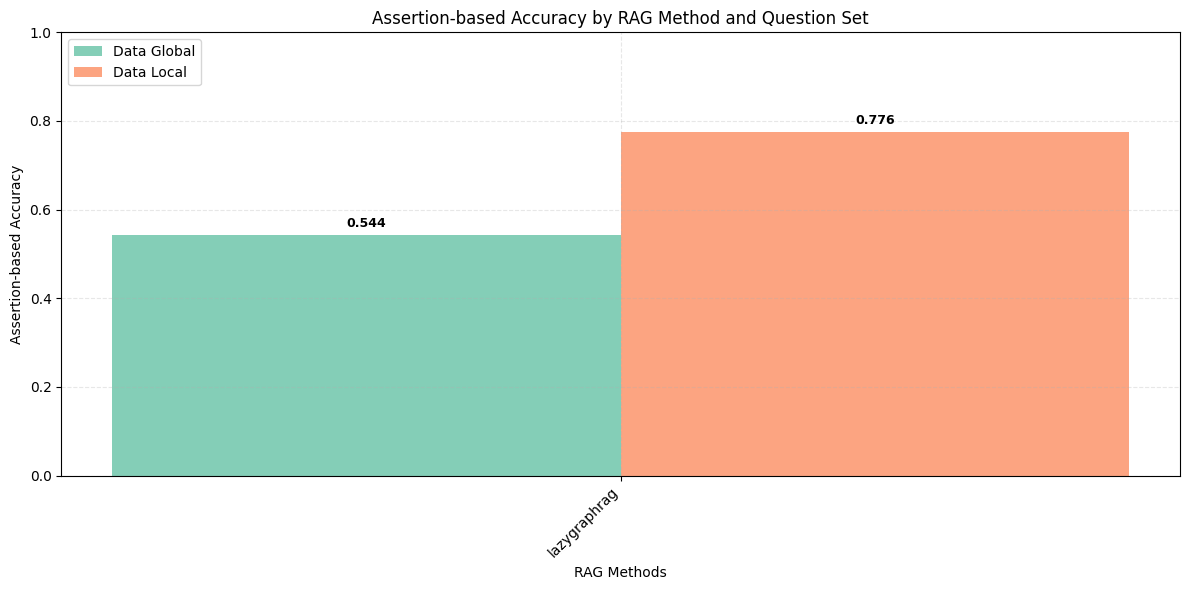

Visualization chart saved to output\assertion_scores

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting style
plt.style.use('default')
sns.set_palette("Set2")  # Better color scheme

# Create grouped bar chart
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Sort by mean accuracy across question sets (lowest to highest)
pivot_summary_reset = pivot_summary.reset_index()
pivot_summary_reset['mean_accuracy'] = pivot_summary_reset.select_dtypes(include='number').mean(axis=1)
pivot_summary_reset = pivot_summary_reset.sort_values('mean_accuracy', ascending=True)

x = range(len(pivot_summary_reset))
width = 0.35

# Get the question sets dynamically
question_set_columns = [col for col in pivot_summary_reset.columns if col not in ['rag_method', 'mean_accuracy']]

# Create bars for each question set with improved colors
colors = sns.color_palette("Set2", len(question_set_columns))
for i, question_set in enumerate(question_set_columns):
    values = pivot_summary_reset[question_set].fillna(0)
    bars = ax.bar([pos + width * i for pos in x], values, width, 
                   label=question_set.replace('_', ' ').title(),
                   color=colors[i], alpha=0.8)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.annotate(f'{height:.3f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xlabel('RAG Methods')
ax.set_ylabel('Assertion-based Accuracy')
ax.set_title('Assertion-based Accuracy by RAG Method and Question Set')
ax.set_xticks([pos + width * (len(question_set_columns) - 1) / 2 for pos in x])
ax.set_xticklabels(pivot_summary_reset['rag_method'], rotation=45, ha='right')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_ylim(0, 1.0)


plt.tight_layout()
plt.savefig(output_dir / "assertion_accuracy_visualization.png", dpi=300, bbox_inches='tight')
plt.show()

rich_print(f"[bold green]Visualization chart saved to {output_dir}[/bold green]")